In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib scikit-learn

In [17]:
#Import required Libraries
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [18]:
#Read data using Pandas
data = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [19]:
#Preprocess the data
from tensorflow.keras.layers import TextVectorization

In [20]:
X = data['comment_text']
y = data[data.columns[2:]].values

In [21]:
#Number of word in the Vocabulary
MAX_FEATURES = 200000 

In [22]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')


In [23]:
#Teach the vectorizer the Vocabulary from our data
vectorizer.adapt(X.values)

In [24]:
#Pass all our comment text to the vectorizer
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [25]:
#Creating a TensorFlow data pipeline
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [26]:
#Partition the data
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [27]:
#Imports for Sequential Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [28]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer- GPU acceleration required for LSTM needs to have tanh activation function
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [29]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [32]:
#Train the model
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 4400s 630ms/step - loss: 0.0621 - val_loss: 0.0457


In [34]:
#Predict
input_text = vectorizer('Thank you for your help!')


In [35]:
res=model.predict(np.expand_dims(input_text,axis=0))

1/1 [==============================] - 1s 749ms/step


In [36]:
(res > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0]])

In [37]:
#Evaluate the Model
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


In [38]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 110ms/step


In [39]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7926282286643982, Recall:0.6974055171012878, Accuracy:0.47843530774116516


In [ ]:
#Save the model
model.save('toxicity.h5')

In [ ]:
#Integrate the model into Gradio App
!pip install gradio jinja2

In [40]:
import gradio as gr

d:\Documents\Anand\Python Testings\madi_re\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Load the model If used at a different environment
#model = tf.keras.models.load_model('toxicity.h5')

In [41]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(data.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [42]:
interface = gr.Interface(fn=score_comment, 
                         inputs=["text"],
                        outputs=["text"])

In [ ]:
interface.launch(share=True,show_error=True)

1/1 [==============================] - 0s 66ms/step


### Gradio Interface

##### Notice the tags for each comment

#### A non threating, non abusive comment
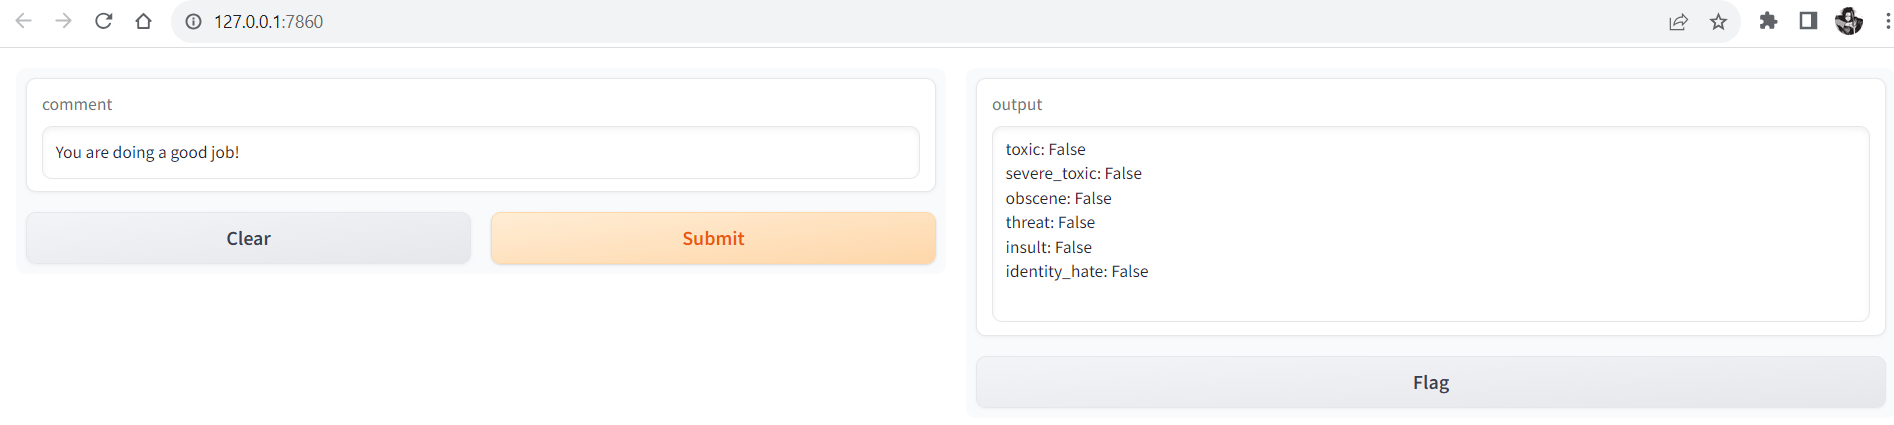

#### A threating, abusive comment
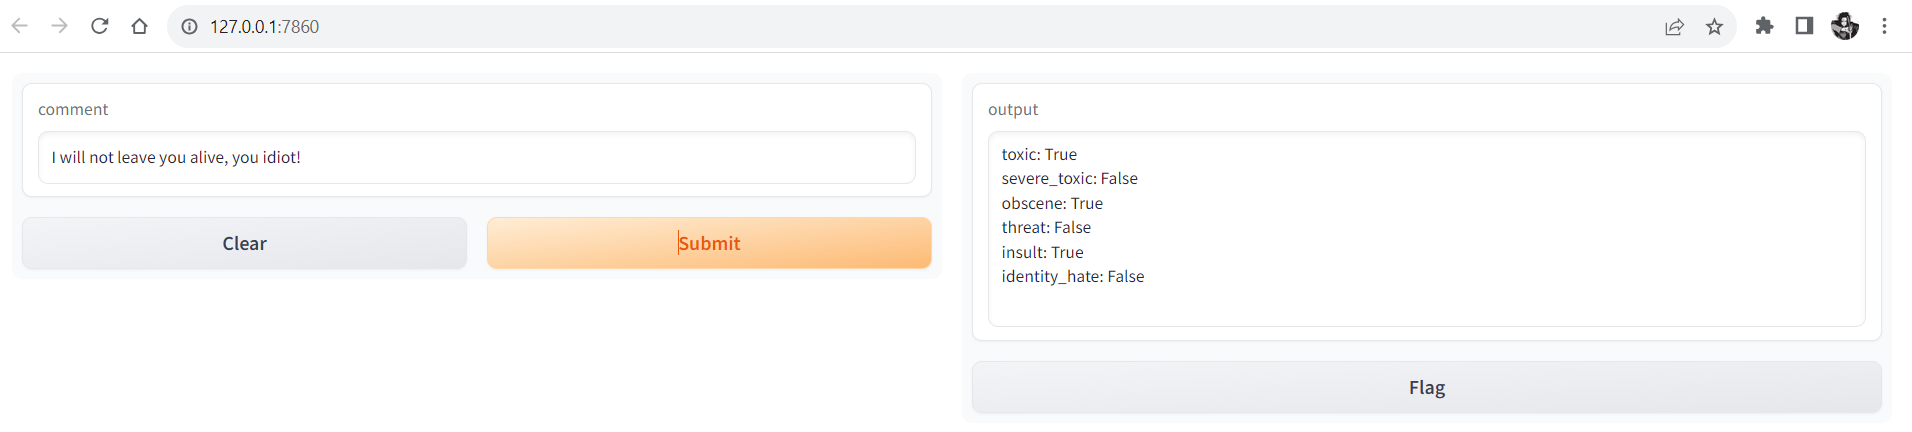